<a href="https://colab.research.google.com/github/olegmyrk/vq-vae-2-tensorflow/blob/master/Notebook_CelebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import backend as Kb
import matplotlib.pyplot as plt

print(tf.__version__)
print(K.__version__)

2.1.0
2.2.4-tf


In [0]:
import os
import hashlib
from urllib.request import urlretrieve
import zipfile
import shutil

def download_extract_celeba(data_path):
    url = 'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip'
    hash_code = '00d2c5bc6d35e252742224ab0c1e8fcb'
    extract_path = os.path.join(data_path, 'img_align_celeba')
    save_path = os.path.join(data_path, 'celeba.zip')
  
    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(save_path):
        urlretrieve(
            url,
            save_path)

    assert hashlib.md5(open(save_path, 'rb').read()).hexdigest() == hash_code, \
        '{} file is corrupted.  Remove the file and try again.'.format(save_path)

    os.makedirs(extract_path)
    try:
        with zipfile.ZipFile(save_path) as zf:
            zf.extractall(data_path)
    except Exception as err:
        shutil.rmtree(extract_path)  # Remove extraction folder if there is an error
        raise err

    # Remove compressed data
    os.remove(save_path)
    return extract_path

In [0]:
dataset_images = sorted(os.listdir(dataset_path))

In [0]:
train_split = int(len(dataset_images)*0.9)
train_images = celeba_images[0:train_split]
validation_images = celeba_images[train_split:]

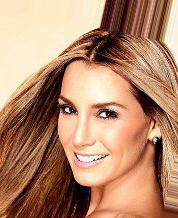

In [157]:
Image.open(os.path.join(dataset_path,train_images[0]))

In [0]:
IMAGE_SIZE = (128, 128)

In [0]:
def load_image_data(image_name):
  image_path = tf.io.read_file(dataset_path + os.path.sep + image_name)
  image = tf.image.decode_jpeg(image_path, channels=3, dct_method='INTEGER_ACCURATE')
  image_size = tf.shape(image)
  print(image)
  face_width = face_height = 178
  j = (image_size[0] - face_width) // 2
  i = (image_size[1] - face_height) // 2
  image = tf.image.crop_to_bounding_box(image, j, i, face_width, face_height)  
  image = tf.image.resize(image, IMAGE_SIZE)
  image = tf.cast(image, tf.float32) / 127.5 - 1
  return image

In [0]:
BATCH_SIZE=64

In [175]:
train_dataset = tf.data.Dataset.from_tensor_slices((dataset_images))
train_dataset = train_dataset.shuffle(len(dataset_images), reshuffle_each_iteration=True).repeat(None)
train_dataset = train_dataset.map(load_image_data, num_parallel_calls=4*BATCH_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

Tensor("DecodeJpeg:0", shape=(None, None, 3), dtype=uint8)


In [0]:
# Hyperparameters
NUM_LATENT_K = 10                 # Number of codebook entries
NUM_LATENT_D = 64                 # Dimension of each codebook entries
BETA = 1.0                        # Weight for the commitment loss

INPUT_SHAPE = tuple(list(IMAGE_SIZE) + [3])
SIZE = None                       # Spatial size of latent embedding
                                  # will be set dynamically in `build_vqvae

VQVAE_BATCH_SIZE = 128            # Batch size for training the VQVAE
VQVAE_NUM_EPOCHS = 20             # Number of epochs
VQVAE_LEARNING_RATE = 3e-4        # Learning rate
VQVAE_LAYERS = [16, 32]           # Number of filters for each layer in the encoder

PIXELCNN_BATCH_SIZE = 128         # Batch size for training the PixelCNN prior
PIXELCNN_NUM_EPOCHS = 10          # Number of epochs
PIXELCNN_LEARNING_RATE = 3e-4     # Learning rate
PIXELCNN_NUM_BLOCKS = 12          # Number of Gated PixelCNN blocks in the architecture
PIXELCNN_NUM_FEATURE_MAPS = 32    # Width of each PixelCNN block